# NDVI Anomaly
Notebook to generate NDVI anomaly, showing changes in NDVI between two time periods. To show actual change two time period of similar seasonality should be used. 
The output is an NDVI anomaly and also a threshold product, the thresholds assocaited with the product can be adjusted depending on what you changes the user is interested in. 

Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

In [125]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

from matplotlib.cm import RdYlGn, Greens

CMAP = "Blues"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
#import datacube utilities
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
from utils_dcal.data_cube_utilities.dc_load import get_product_extents
from utils_dcal.data_cube_utilities.dc_time import dt_to_str
from utils_dcal.data_cube_utilities.dc_display_map import display_map
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from utils_dcal.data_cube_utilities.dc_rgb import rgb
from utils_sac.createAOI import create_lat_lon
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_sac.createindices import NDVI
from utils_sac.fromDCALscripts import threshold_plot


# NDVI Anomaly 
Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

# Choose Platform and Product

In [127]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='ndvi anomoly')

## Set Variables

In [128]:
#area of interest: load in as wkt
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#set-project: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"
#set resolution_if using Landsat min 30m, if sentinel min 10m 
res = (200)
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform = 'LANDSAT_4'

In [129]:
# Select the baseline time period (start and end)
baseline_time_period = (datetime(1990,1,1), datetime(1995,12,30))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(1990,1,1), datetime(1995,12,30)) 

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
mosaic_type = "median"

# Select a baseline NDVI threshold range
# The analysis will only consider pixels in this range for change detection
# Example: use 0.6 to 0.9 for dense vegetation
# grasslands are 0.2 to 0.6
# all vegetation 0.2 to 1
ndvi_baseline_threshold_range = (0.2, 1)  

In [130]:
# Select NDVI Anomaly Threshold Range
# We are looking for pixels that have lost significant vegetation
# NDVI losses are typically 0.1 or more for deforestation

minimum_change = -0.7
maximum_change = -0.1

### Create AOI

In [131]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [132]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [133]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

In [134]:
#create resolution
resolution = (-res, res)

### Import products from datacube 

In [135]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}

>#### Load Data ( Baseline, Analysis) 

In [136]:
baseline_ds = dc.load(
    time = baseline_time_period,
    **query
)


In [137]:
analysis_ds = dc.load(
    time = analysis_time_period,
    **query
)

### Check if loads are valid

In [138]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [139]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [140]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

#### Create CLoud Mask
Generating boolean masks that highlight valid pixels
Pixels must be cloud-free over land or water to be considered

In [141]:
from utils_sac.clean_mask import landsat_qa_clean_mask
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform)

In [142]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

### Perform Mosaic
 Use clean masks in a time series composite

In [143]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [144]:
baseline_compositor = mosaic_function[mosaic_type]
analysis_compositor = mosaic_function[mosaic_type]

In [145]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask)

### Mask out Water

In [146]:
water_class_base = wofs_classify(baseline_composite, mosaic=True, x_coord='x', y_coord='y').wofs
baseline_composite = baseline_composite.copy(deep=True).where((baseline_composite != np.nan) & (water_class_base == 0))
water_class_analy = wofs_classify(analysis_composite, mosaic=True, x_coord='x', y_coord='y').wofs
analysis_composite = analysis_composite.copy(deep=True).where((analysis_composite != np.nan) & (water_class_analy == 0))

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f193f5482b0>)

<Figure size 432x216 with 0 Axes>

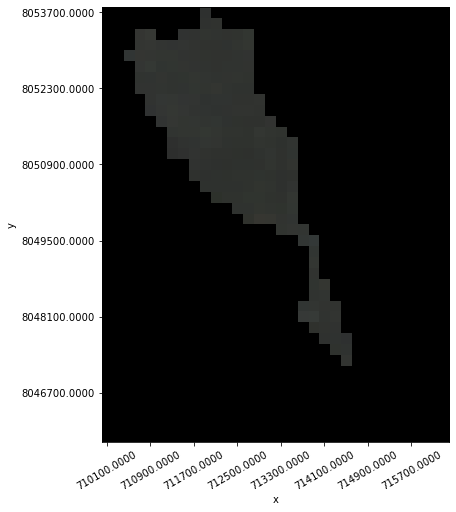

In [147]:
plt.figure(figsize = (6,3))
rgb(baseline_composite, x_coord='x', y_coord='y')

In [148]:
print(baseline_composite)

<xarray.Dataset>
Dimensions:   (x: 32, y: 40)
Coordinates:
  * y         (y) float64 8.054e+06 8.054e+06 8.053e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.101e+05 7.103e+05 7.105e+05 ... 7.161e+05 7.163e+05
Data variables:
    green     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    red       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    blue      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    nir       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    swir1     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    swir2     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    pixel_qa  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan


(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f193e393908>)

<Figure size 432x216 with 0 Axes>

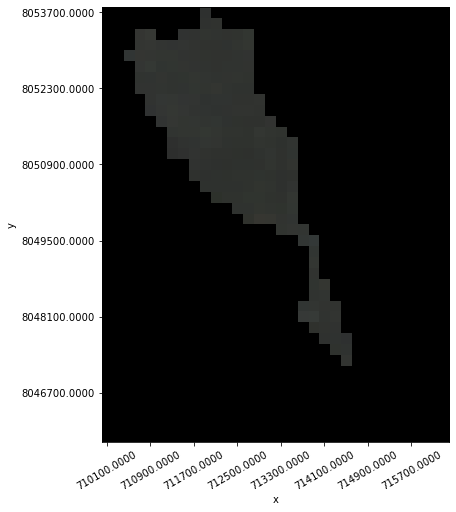

In [149]:
plt.figure(figsize = (6,3))
rgb(analysis_composite, x_coord='x', y_coord='y')

### Baseline Mosaic using the NDVI Threshold Range
To only include pixels within our interest threshold range

In [150]:
_min, _max = ndvi_baseline_threshold_range  
baseline_ndvi_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    

In [151]:
def aspect_ratio_helper(ds, fixed_width = 15):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [152]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

<Figure size 1080x1350 with 0 Axes>

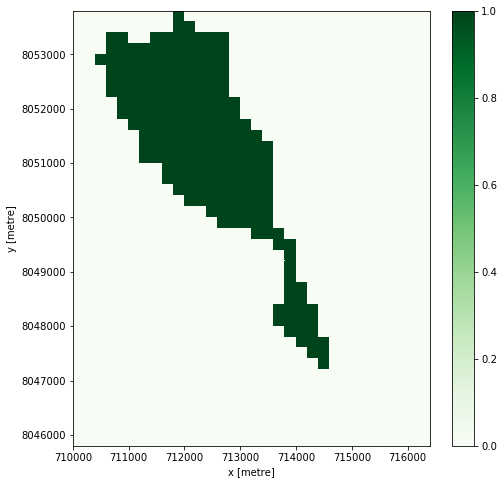

In [153]:
# This is the baseline NDVI threshold plot that shows GREEN pixels in the threshold range
plt.figure(figsize = aspect_ratio_helper(baseline_ndvi_filter_mask)) 
plt.figure(figsize = (8,8))
baseline_ndvi_filter_mask.plot(cmap = "Greens")

In [154]:
baseline_composite = baseline_composite.where(baseline_ndvi_filter_mask)

# NDVI Anomaly

In [155]:
#calculate NDVI
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

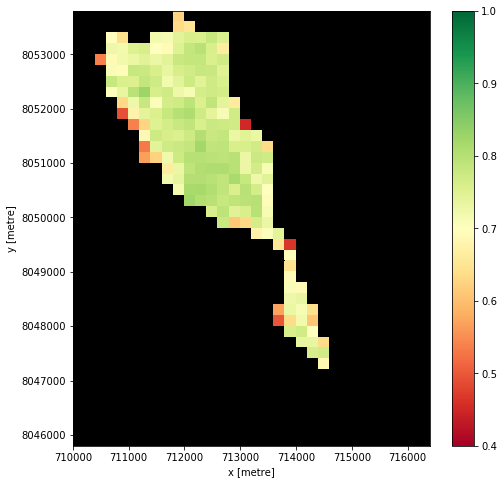

In [156]:
plt.figure(figsize = (8,8))
ndvi_baseline_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

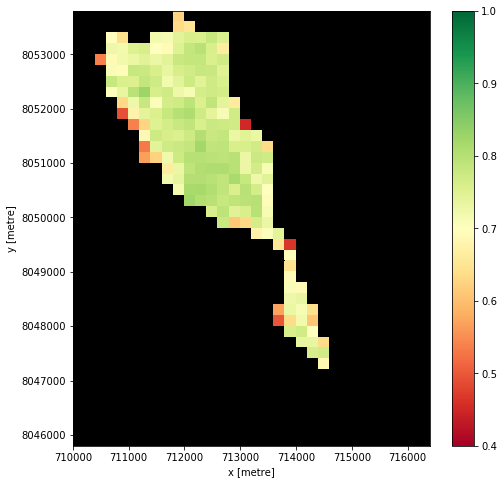

In [157]:
plt.figure(figsize = (8,8))
ndvi_analysis_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

In [158]:
#calculate ndvi anomaly
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

NDVI Anomaly Plot


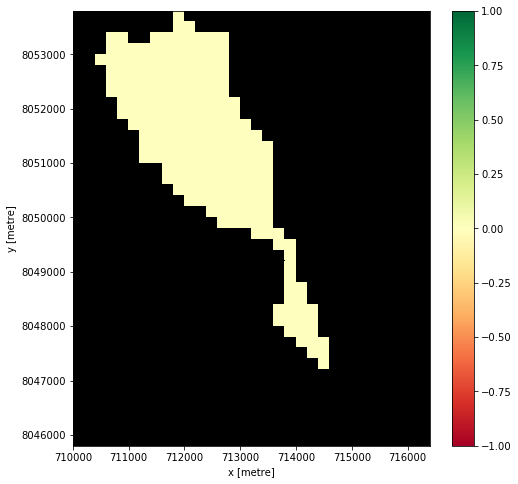

In [159]:
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(vmin=-1, vmax=1, cmap = RdYlGn)

Discretized/Binned plot

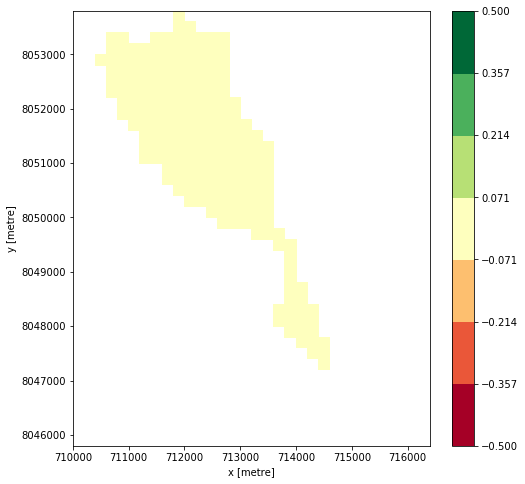

In [160]:
#plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(levels = 8, vmin=-0.5, vmax=0.5, cmap = RdYlGn)

In [161]:
# from dc_notebook_utilities import create_discrete_color_map
from utils_dcal.data_cube_utilities.plotter_utils import create_discrete_color_map
cmap = create_discrete_color_map(data_range=(-1,1), 
                                 th=[0.0], colors=[(240,93,94), (126,243,125)])
cmap.set_bad("black", 1.)

>#### NDVI Anomaly

This product shows the following ...<br>
BLACK = Cloud or Pixels NOT in the baseline threshold range<br>
GREEN = Pixels with an increase in NDVI<br>
RED = Pixels with a decrease in NDVI<br>

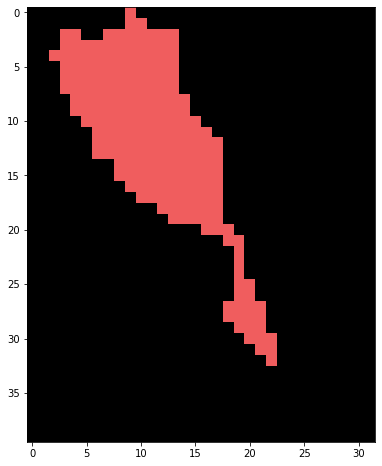

In [162]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
plt.imshow(ndvi_anomaly.values, cmap=cmap, vmin=-1, vmax=1)
plt.show()

In [212]:
print(ndvi_anomaly)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05


# NDVI Anomaly Threshold Product

>#### NDVI Change Distribution
Threshold range, highlighted in red

In [163]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values)) 

In [164]:
if hasattr(ndvi_anomaly, 'x'):
    ndvi_anomaly = ndvi_anomaly.rename({"x":"latitude", "y":"longitude"})
else:
    print('latitude and longitude exist')

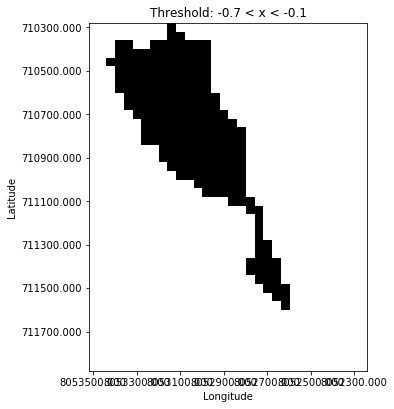

In [165]:
threshold_plot(ndvi_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 8)

In [166]:
ndvi_anomaly_thres = np.logical_and(ndvi_anomaly > minimum_change, ndvi_anomaly < maximum_change) 
#masked  = np.zeros(ndvi_anomaly.values.shape).astype(bool)

In [177]:
ndvi_anomaly_thres2 = ndvi_anomaly.where(ndvi_anomaly > minimum_change, ndvi_anomaly < maximum_change)

In [216]:
print(ndvi_anomaly_thres2)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05


In [213]:
new2 = ndvi_anomaly_thres2.where(ndvi_anomaly != np.nan)

In [214]:
print(new2)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05


In [190]:
print(ndvi_anomaly)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05


In [228]:
from datacube.storage import masking
mask_here = masking.mask_invalid_data(ndvi_anomaly)

In [229]:
ndvi_anomaly_thres.where(mask_here)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05

In [224]:
test2 = ndvi_anomaly_thres2.where(ndvi_anomaly != np.nan)

In [225]:
print(test2)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05


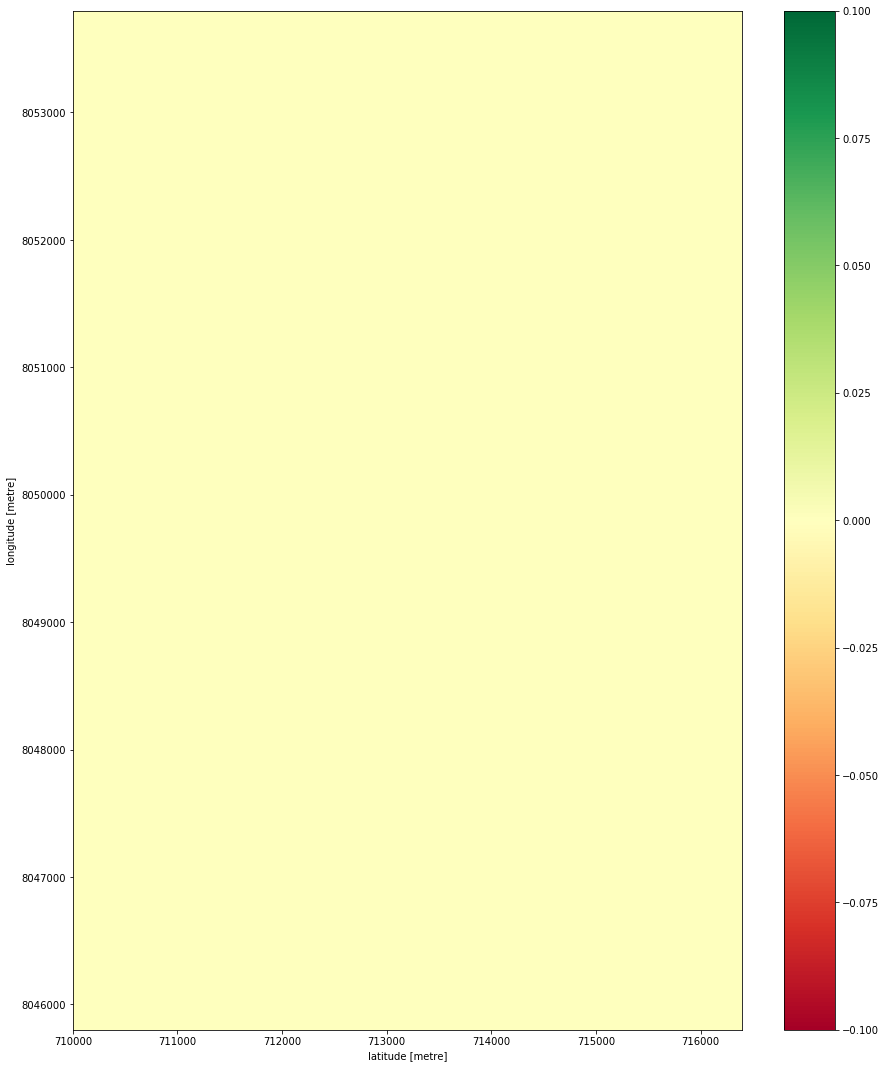

In [226]:
plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly_thres2)) 
test2.plot(cmap = "RdYlGn")

In [203]:
#test = ndvi_anomaly_thres.np.nan.where(test2 == np.nan)
test = ndvi_anomaly_thres2.where(ndvi_anomaly)
new = xr.DataArray.to_masked_array(self, copy: bool = True)

 #blue = src.read(1, masked=True)
#analysis_composite = analysis_composite.copy(deep=True).where((analysis_composite != np.nan)
#masked.plot(cmap = "RdYlGn")

In [204]:
print(test)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05


[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]


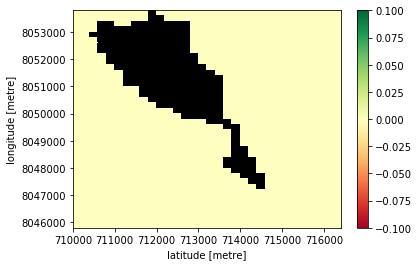

In [185]:
test.plot(cmap = "RdYlGn")

In [198]:
print(test.shape)

(40, 32)


In [174]:
print(test)

<xarray.DataArray (longitude: 40, latitude: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * latitude   (latitude) float64 7.101e+05 7.103e+05 ... 7.161e+05 7.163e+05
